# Домашнее задание №2. Оптимальные портфели инвестиций
#### Выполнили: Мельников, Малышева, Селивановская

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy
import math
import seaborn as sns
import warnings
from random import randint
from scipy.optimize import minimize
from matplotlib.ticker import ScalarFormatter
warnings.filterwarnings('ignore')

from IPython.display import clear_output

## Загрузка данных, предобработка, рассчет логарифмической доходности

In [2]:
# todo: turn the code below into a function 
# done

def download_data(tickers_list, local_file=False, reduce_tickers=False, add_index=False):   
        
    if not local_file:
        data = yf.download(tickers_list,'2019-01-02','2019-12-31') # ! 
    else:
        data = pd.read_pickle('ticker_data')
    
    data = data.drop(columns = ['Low', 'High', 'Open', 'Close'])
    
    index = pd.read_csv('index_ixic.csv', sep=",")
    index = index.drop(columns = ['Low', 'High', 'Open', 'Close'])
    
    adj_close = data['Adj Close'] # adjusted closing price
    volume = data['Volume'] # sales volume

    adj_close.reset_index(level=0, inplace=True) # set index from date to int
    volume.reset_index(level=0, inplace=True)

    for i in range(0, len(adj_close['Date'])):
        volume.loc[i, 'Date'] = str(volume['Date'][i].date())
        adj_close.loc[i, 'Date'] = str(adj_close['Date'][i].date())


    adj_indexes = set(adj_close['Date'].to_list())
    ind_indexes = set(index['Date'].to_list())
    diff = adj_indexes.difference(ind_indexes)

    adj_close = adj_close.loc[adj_close['Date'] != '2019-11-28']
    volume = volume.loc[volume['Date'] != '2019-11-28']

    #handling missing values
    adj_close = adj_close.dropna(axis=1, how='any')
    volume = volume.dropna(axis=1, how='any')

    #add the index data to the main data
    if add_index:
        adj_close['IXIC'] = index['Adj Close']
        volume['IXIC'] = index['Volume']

    #delete last day as ixic is nan
    adj_close = adj_close.loc[adj_close['Date'] != '2019-12-30']
    volume = volume.loc[volume['Date'] != '2019-12-30']

    #reindex after drop
    adj_close.reset_index(drop=True, inplace=True)

    #reduce the number of tickers
    
    if reduce_tickers is True:
        tickers_to_delete = adj_close.columns.to_list()
        tickers_to_delete.remove('Date')
        tickers_to_delete.remove('IXIC')
        tickers_to_delete = tickers_to_delete[::2]
        adj_close.drop(tickers_to_delete, inplace=True, axis=1) 
        volume.drop(tickers_to_delete, inplace=True, axis=1) 

    # calculate logarithmic returns
    log_returns = pd.DataFrame(index = adj_close.index, columns = adj_close.columns)
    log_returns['Date'] = adj_close['Date']
    tickers = adj_close.columns.to_list()
    tickers.remove('Date')

    #num_days=len(log_returns['AADR'])
    num_days=len(log_returns[tickers[0]])
    print(len(tickers))
    
    
    for ticker in tickers:
        for i in range(1, num_days):
            log_returns.loc[i, ticker] = np.log(adj_close.loc[i, ticker]/adj_close.loc[i-1, ticker])
    #dropping first day
    log_returns = log_returns.dropna(axis=0, how='any')
    log_returns.reset_index( drop=True, inplace=True) 
    
    if add_index:
        
        index_log_returns = log_returns.loc[:, ["Date", "IXIC"]]
        log_returns.drop(columns=['IXIC'], axis=0, inplace=True)
        
        return log_returns, index_log_returns
    
    return log_returns

## 1.Efficient frontier. 

Выбрать на рынке набор из 50 акций. Объясните ваш выбор. Построить эффективный фронт портфелей инвестиций без ограничений на короткие позиции и эффективный фронт с запретом коротких позиций. Сравнить эффективные фронты и сделать выводы. При построении эффективных фронтов вычислить портфели с минимальным риском и отметить их на соответствующем эффективном фронте. Рассмотреть портфель с равными долями вложения капитала и оценить, как далек этот портфель от эффективного фронта. Тот же вопрос для индекса рынка.

### Выберем первые 50 акций по алфавиту из списка компаний, формирующих индекс Nasdaq-100.

Этот индекс включает в себя 100 крупнейших по капитализации компаний, акции которых торгуются на бирже NASDAQ. 

In [3]:
nasdaq_100_tickers = list(pd.read_csv("nasdaq-100_tickers.csv", header=None)[0])
log_returns50, index_log_returns = download_data(nasdaq_100_tickers, local_file=False, reduce_tickers=False, add_index=True)
log_returns50 = log_returns50.iloc[:, 0:51] # отбираем 50 компаний
tickers50 = log_returns50.columns[1::]

[*********************100%***********************]  103 of 103 completed
99


In [4]:
# for testing purposes
'''
tickers50 = []
for i in range(5):
    tickers50.append(tickers[randint(0, len(tickers))])
tickers50

x = np.random.random(5)
x = x/np.sum(x) # нормализация
x = np.array(x)

log_returns50 = log_returns[tickers50]
'''

'\ntickers50 = []\nfor i in range(5):\n    tickers50.append(tickers[randint(0, len(tickers))])\ntickers50\n\nx = np.random.random(5)\nx = x/np.sum(x) # нормализация\nx = np.array(x)\n\nlog_returns50 = log_returns[tickers50]\n'

In [5]:
# выборочные средние 
def calc_sample_means(returns):
    tickers = returns.columns[1:] # предполагаем, что первый столбец - дата 
    sample_means = pd.DataFrame(columns = ['Sample mean (E)'], index = tickers)
    for ticker in tickers:
        mean = np.mean(returns[ticker])
        sample_means['Sample mean (E)'][ticker] = mean
    return sample_means

'''
sample_means50 = pd.DataFrame(columns = ['Sample mean (E)'], index = tickers50) # sample means (E) for each of the 50 stocks

for ticker in tickers50:
    mean = np.mean(log_returns50[ticker])
    sample_means50['Sample mean (E)'][ticker] = mean
'''

"\nsample_means50 = pd.DataFrame(columns = ['Sample mean (E)'], index = tickers50) # sample means (E) for each of the 50 stocks\n\nfor ticker in tickers50:\n    mean = np.mean(log_returns50[ticker])\n    sample_means50['Sample mean (E)'][ticker] = mean\n"

In [6]:
# матрица выборочных ковариаций для 50 активов
def calc_sample_cov(returns, sample_means, verbose=True):
    tickers = returns.columns[1:]
    sample_cov = pd.DataFrame(columns = tickers, index = tickers)
    
    status_count = 0
    for ticker1 in tickers:
    
        if verbose:
            status_count += 1
            clear_output()
            print(f"{status_count}/{len(tickers)}")

        for ticker2 in tickers:
            sum_ = 0
            N = returns[ticker2].shape[0] # количество наблюдений
            for i in range(N):
                sum_ += (returns[ticker1][i] - float(sample_means.loc[ticker1])) * (returns[ticker2][i] - float(sample_means.loc[ticker2]))

            sample_cov[ticker1][ticker2] = sum_ / (N)
    return sample_cov
    
'''
sample_cov50 = pd.DataFrame(columns = tickers50, index = tickers50) # sample covariance for 50 stocks

status_count = 0
for ticker1 in tickers50:
    status_count += 1
    clear_output()
    print(f"{status_count}/{len(tickers50)}")
    for ticker2 in tickers50:
        sum_ = 0
        N = log_returns50[ticker2].shape[0] # количество наблюдений
        for i in range(N):
            sum_ += (log_returns50[ticker1][i] - float(sample_means50.loc[ticker1])) * (log_returns50[ticker2][i] - float(sample_means50.loc[ticker2]))
        
        sample_cov50[ticker1][ticker2] = sum_ / (N)

'''

'\nsample_cov50 = pd.DataFrame(columns = tickers50, index = tickers50) # sample covariance for 50 stocks\n\nstatus_count = 0\nfor ticker1 in tickers50:\n    status_count += 1\n    clear_output()\n    print(f"{status_count}/{len(tickers50)}")\n    for ticker2 in tickers50:\n        sum_ = 0\n        N = log_returns50[ticker2].shape[0] # количество наблюдений\n        for i in range(N):\n            sum_ += (log_returns50[ticker1][i] - float(sample_means50.loc[ticker1])) * (log_returns50[ticker2][i] - float(sample_means50.loc[ticker2]))\n        \n        sample_cov50[ticker1][ticker2] = sum_ / (N)\n\n'

In [7]:
sample_means50 = calc_sample_means(log_returns50)
sample_cov50 = calc_sample_cov(log_returns50, sample_means50, verbose=True)
#sample_std_devs50 = calc_sample_std_devs(...)

50/50


In [8]:
# Выборочное стандартное отклонение для 50 активов
sample_std_devs50 = pd.DataFrame(data= pd.DataFrame(np.diag(sample_cov50)**0.5,
                                columns = ['Sample standard deviation (σ)'],
                                index = tickers50)) # # sample standard deviation (σ) for each of the 50 stocks

### Изобразим выбранные акции на графике

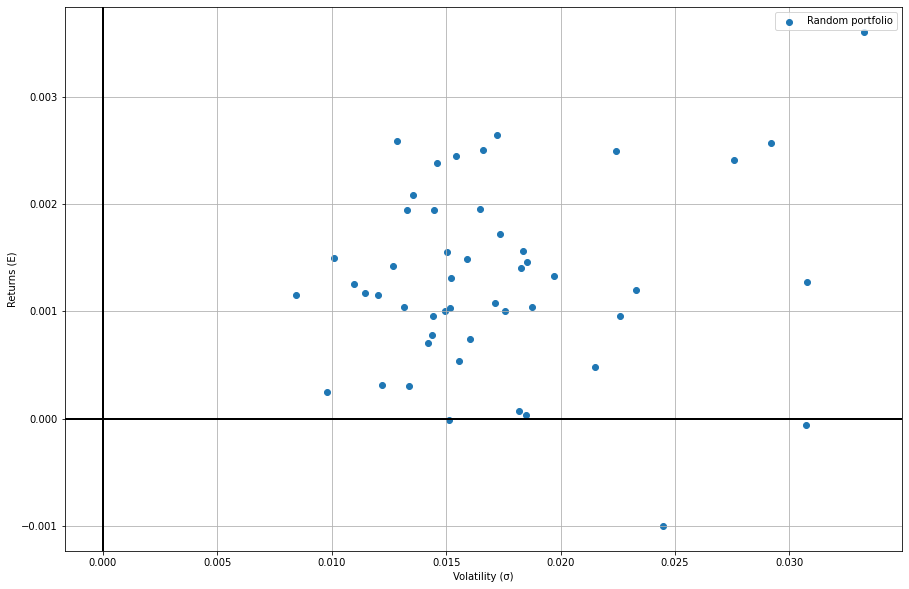

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# random portfolios plot
ax.scatter(sample_std_devs50, sample_means50, marker="o", label="Random portfolio")
   
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()


### Сгенерируем несколько случайных портфелей и изобразим их на графике

In [10]:
def calc_portfolio_return(x, means): # доходность портфеля, принимает np.array
    #E = sum(means.iloc[0:n_stocks] * x)
    E = np.matmul(x, means)
    E = float(E)
    return E

def calc_portfolio_volatility(x, cov_matrix): # риск портфеля, хотим найти такой вектор весов x, что риск стремится к минимуму
    sigma_sq = np.matmul(np.matmul(x, cov_matrix), x.T)
    sigma_sq = float(sigma_sq)
    return sigma_sq

def generate_random_portfolios(means, cov_matrix, short_sales=False, n_portfolios=10000):
      
    n_stocks = means.shape[0]
    
    portfolio_means = [] # returns per portfolio
    portfolio_std_devs = [] # standard deviations per portfolio
    
    x_range = () # область значений веса акции в портфеле
    if short_sales:
        x_range = (-1, 1)
    else:
        x_range = (0, 1)
        
    for portfolio in range(n_portfolios):
        x = np.random.uniform(x_range[0], x_range[1],n_stocks)
        x = x/sum(x) # нормализация
        #x = x/abs(sum(x)) # weird
        x = np.array(x)
        #print(x, x.sum())
        #portfolio_sample_means.append(sum(sample_means.iloc[0:n_stocks] * x)) # R - доходность       
        #portfolio_std_devs.append(np.matmul(np.matmul(x, covariance_matrix.iloc[0:n_stocks, 0:n_stocks]), x.T)) # риски    
        portfolio_means.append(calc_portfolio_return(x, means))
        portfolio_std_devs.append(calc_portfolio_volatility(x, cov_matrix))
        
    return portfolio_std_devs, portfolio_means


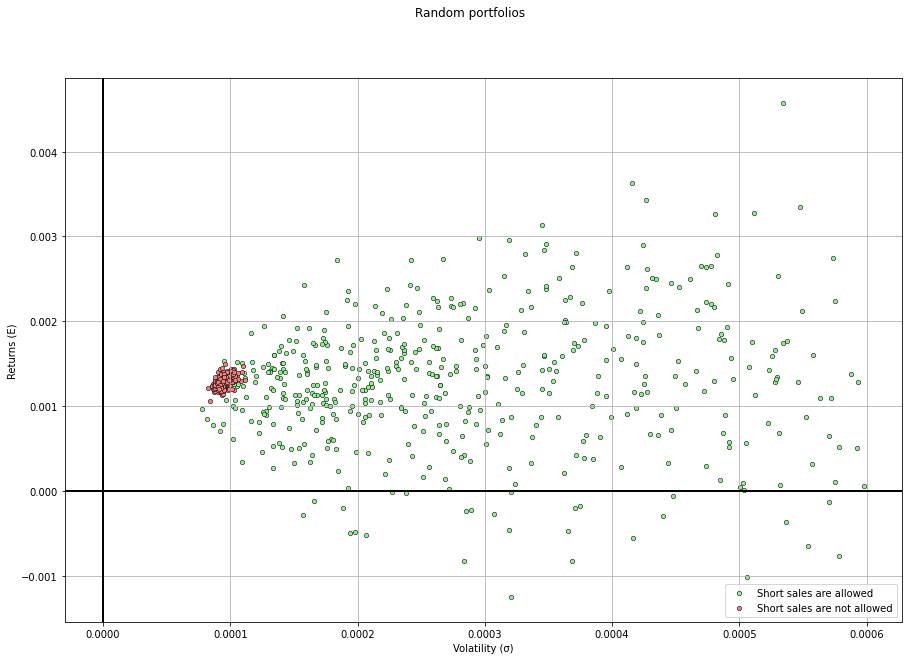

In [11]:
random_portfolios_short_std_devs, random_portfolios_short_means = generate_random_portfolios(sample_means50, sample_cov50, short_sales=True, n_portfolios=1000)
random_portfolios_no_short_std_devs, random_portfolios_no_short_means = generate_random_portfolios(sample_means50, sample_cov50, short_sales=False, n_portfolios=200)

# удаление слишком больших значений 
indices = [ind for ind in range(len(random_portfolios_short_std_devs)) if random_portfolios_short_std_devs[ind] < 0.0006]
indices = [ind for ind in indices if random_portfolios_short_means[ind] < 0.01]
random_portfolios_short_std_devs = [random_portfolios_short_std_devs[i] for i in indices]
random_portfolios_short_means = [random_portfolios_short_means[i] for i in indices]

fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Random portfolios")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# random portfolios plot
ax.scatter(random_portfolios_short_std_devs, random_portfolios_short_means, marker="o", color='lightgreen',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are allowed")
ax.scatter(random_portfolios_no_short_std_devs, random_portfolios_no_short_means, marker="o", color='lightcoral',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are not allowed")

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()


### Найдем фронты эффективных портфелей

In [12]:
def optimize_portfolio_volatility(means, cov_matrix, short_sales=True, custom_return=False, target_return=None): # x - weights of a portfolio
    n_stocks = means.shape[0]
    
    # Генерация случайного начального решения 
    x_initial = np.random.random(n_stocks)
    #x_initial = np.ones(n_stocks)
    x_initial = x_initial/np.sum(x_initial) # нормализация
    x_initial = np.array(x_initial)
    
    #print(f"X initial for {n_stocks}: {x_initial}")
    
    # Ограничения 
    
    constraints = [{'type': 'eq',
                    'fun': lambda x: x.sum() - 1.0
                   }]
    
    # если хотим найти наименьшее значение риска портфеля при заданном уровне доходности
    if custom_return:
        if target_return is None:
            print("Target Return is not set!")
            return 
        else:
            constraints.append({'type': 'eq', 
                                'fun': lambda x: calc_portfolio_return(x, means) - target_return
                               })
            print(f"Looking for a solution for {target_return}")
            
    # Ограничения на область значений x
    x_bounds = []
    if short_sales:
        # шорты разрешены, x принимает любое значение
        for i in range(n_stocks):
            x_bounds.append((None, None))
    else:
        # шорты запрещены, x принимает значение от 0 до 1
        for i in range(n_stocks):
            x_bounds.append((0, 1))        
  
    result = scipy.optimize.minimize(calc_portfolio_volatility, # функция, которую хотим оптимизировать
                                     x_initial, # начальное решение 
                                     args=(cov_matrix), # дополнительные аргументы целевой функции
                                     method='SLSQP', # метод оптимизации (МНК)
                                     constraints=constraints, # ограничения 
                                     bounds=x_bounds, # ограничения на значения x
                                     options={'maxiter':1000, 'disp': False},
                                     tol=1e-15 # tolerance? somehow fixes the issue lol 1e-15
                                    )
    
    if result.success:
        return result.x
    else:
        print("Couldn't find minimum")
        return

In [13]:
# Пример с пары 

means = pd.DataFrame(data=np.array([0.8, 0.4]))
cov = pd.DataFrame(data=np.array([[0.04, 0],
                [0, 0.04]]))

ans = optimize_portfolio_volatility(means, cov, short_sales=True)
print(ans, sum(ans))
print(calc_portfolio_volatility(ans, cov))

[0.50000001 0.49999999] 1.0
0.020000000000000004


#### Оптимальный портфель с разрешенными короткими продажами

In [14]:
x_opt_short = optimize_portfolio_volatility(sample_means50, sample_cov50, short_sales=True)

opt_short_return = calc_portfolio_return(x_opt_short, sample_means50)
opt_short_volatility = calc_portfolio_volatility(x_opt_short, sample_cov50)
print(f"Pareto optimal Portfolio (short sales are allowed)\n {x_opt_short} ")
print(f"Portfolio's Volatility: {opt_short_volatility}, Return: {opt_short_return}")

Pareto optimal Portfolio (short sales are allowed)
 [-0.03394865  0.00298005 -0.01401305  0.02797978  0.01578196  0.37466424
 -0.01321405 -0.00468041 -0.033013    0.03203247  0.03765375 -0.07006087
  0.01873257 -0.00699839  0.04680511  0.0210807  -0.007654    0.0082338
 -0.00692563 -0.13319192  0.01368376  0.02874671  0.08503135  0.08165563
 -0.03188255  0.11604101  0.06839275 -0.00633701  0.04864739  0.0923043
  0.08223953  0.03336999 -0.0145548   0.04597962 -0.00054372  0.06532639
  0.05165172 -0.03269685 -0.00046372 -0.04063769  0.03236936  0.34745353
 -0.32143475  0.08269397 -0.05381927  0.00446217  0.00536071  0.02426208
 -0.00319843 -0.06634765] 
Portfolio's Volatility: 2.6699803521086236e-05, Return: 0.0008098489139765838


#### Эффективный фронт с разрешенными короткими продажами

Looking for a solution for 0.0008098489139765838
Looking for a solution for 0.0011643101457569634
Looking for a solution for 0.0015187713775373429
Looking for a solution for 0.0018732326093177226
Looking for a solution for 0.002227693841098102
Looking for a solution for 0.002582155072878482
Looking for a solution for 0.0029366163046588615
Looking for a solution for 0.003291077536439241
Looking for a solution for 0.0036455387682196205
Looking for a solution for 0.004


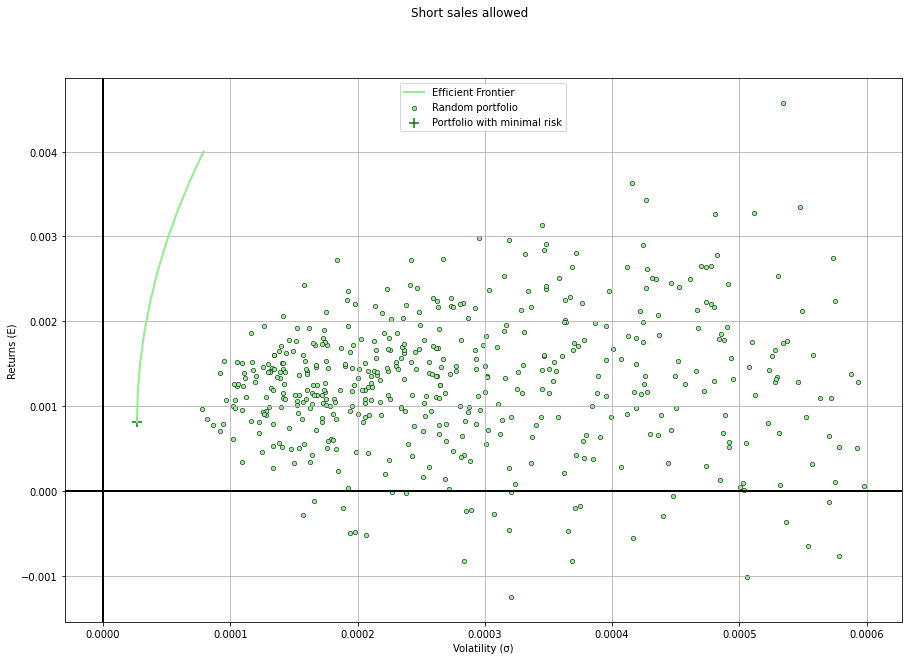

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Short sales allowed")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')


# random portfolios plot
#ax.scatter(random_portfolios_short_std_devs, random_portfolios_short_means, marker="g", s=2, label="Random portfolio")
ax.scatter(random_portfolios_short_std_devs, random_portfolios_short_means, marker="o", color='lightgreen',
           edgecolors= 'black', linewidth=0.5, s=20, label="Random portfolio")

# optimal frontier plot
target_returns_short = np.linspace(opt_short_return, 0.004, 10)
opt_volatilities_short = []

for target_return in target_returns_short:
    x_opt = optimize_portfolio_volatility(sample_means50, sample_cov50, short_sales=True, custom_return=True, target_return=target_return)
    #opt_return = calc_portfolio_return(x_opt, sample_means50)
    opt_volatility = calc_portfolio_volatility(x_opt, sample_cov50)
    opt_volatilities_short.append(opt_volatility)

# min risk plot 
ax.scatter(opt_short_volatility, opt_short_return, color="g", marker="+", s=100, label="Portfolio with minimal risk")    
    
ax.plot(opt_volatilities_short, target_returns_short, color="lightgreen", linewidth=2, label="Efficient Frontier")      
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()



#### Оптимальный портфель с запрещенными короткими продажами

In [16]:
x_opt_no_short = optimize_portfolio_volatility(sample_means50, sample_cov50, short_sales=False)

opt_no_short_return = calc_portfolio_return(x_opt_no_short, sample_means50)
opt_no_short_volatility = calc_portfolio_volatility(x_opt_no_short, sample_cov50)
print(f"Pareto optimal Portfolio (short sales are NOT allowed)\n {x_opt_no_short} ")
print(f"Portfolio's Volatility: {opt_no_short_volatility}, Return: {opt_no_short_return}")

Pareto optimal Portfolio (short sales are NOT allowed)
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.87457798e-18
 2.07895827e-19 4.03176280e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.29496072e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.33092578e-18 1.35782817e-02
 2.19152219e-02 1.16058878e-18 1.47799351e-19 0.00000000e+00
 3.97574199e-18 7.28652353e-18 4.98497982e-02 4.79318651e-02
 1.20477397e-02 1.16259859e-01 2.76700174e-02 6.68672546e-19
 4.58726124e-02 8.34765345e-03 5.15008415e-02 4.68162372e-02
 0.00000000e+00 1.18886779e-02 5.35412287e-21 4.32877339e-02
 5.32550692e-02 4.18425022e-19 0.00000000e+00 5.14276036e-19
 3.65250467e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.61160319e-19 1.96879789e-18 0.00000000e+00 5.37978552e-19
 1.04651309e-18 3.00611529e-18] 
Portfolio's Volatility: 3.396051192298037e-05, Return: 0.0010070508035799116


#### Эффективный фронт с разрешенными короткими продажами

Looking for a solution for 0.0010070508035799116
Looking for a solution for 0.0012284896031821437
Looking for a solution for 0.0014499284027843758
Looking for a solution for 0.0016713672023866077
Looking for a solution for 0.0018928060019888398
Looking for a solution for 0.0021142448015910717
Looking for a solution for 0.0023356836011933038
Looking for a solution for 0.002557122400795536
Looking for a solution for 0.002778561200397768
Looking for a solution for 0.003


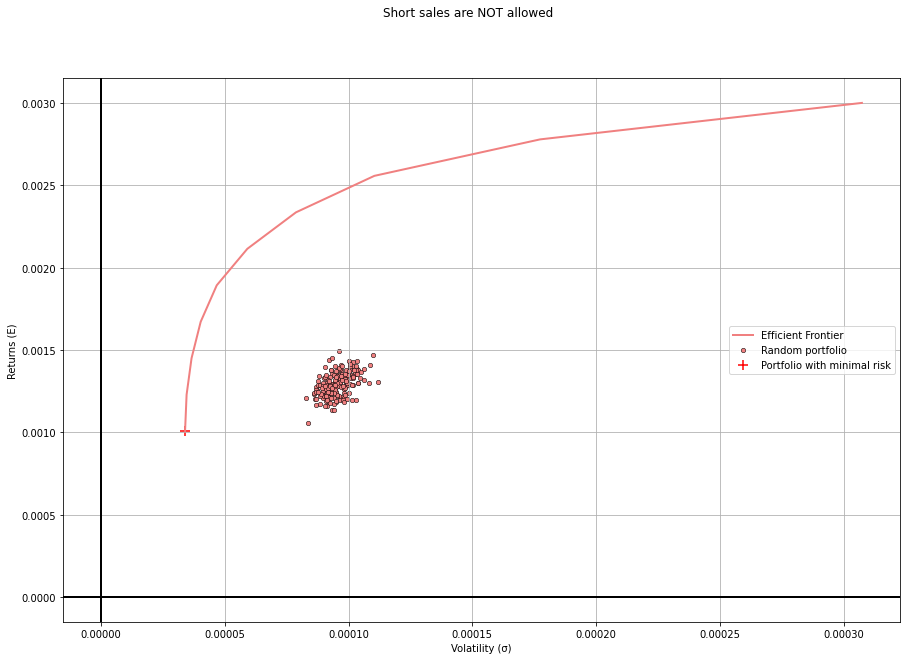

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Short sales are NOT allowed")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# random portfolios plot
ax.scatter(random_portfolios_no_short_std_devs, random_portfolios_no_short_means, marker="o", color='lightcoral',
           edgecolors= 'black', linewidth=0.5, s=20, label="Random portfolio")

# optimal frontier plot
target_returns_no_short = np.linspace(opt_no_short_return, 0.003, 10)
opt_volatilities_no_short = []

for target_return in target_returns_no_short:
    x_opt = optimize_portfolio_volatility(sample_means50, sample_cov50, short_sales=False, custom_return=True, target_return=target_return)
    #opt_return = calc_portfolio_return(x_opt, sample_means50)
    opt_volatility = calc_portfolio_volatility(x_opt, sample_cov50)
    opt_volatilities_no_short.append(opt_volatility)

# min risk plot 
ax.scatter(opt_no_short_volatility, opt_no_short_return, color="r", marker="+", s=100, label="Portfolio with minimal risk")  
    
ax.plot(opt_volatilities_no_short, target_returns_no_short, color="lightcoral", linewidth=2, label="Efficient Frontier")      
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()



### Изобразим на одном графике эффективные фронты, и оптимальные портфели

In [18]:
# рассчитаем доходность и риск портфеля с равными долями и индекса рынка

# генерация портфеля с равными долями
n_stocks = sample_means50.shape[0]
x_eq_w = np.ones(n_stocks) # x equally weighted, i. e. equally weighted portfolio 
x_eq_w = x_eq_w/np.sum(x_eq_w) # нормализация
x_eq_w = np.array(x_eq_w)

# рассчет доходности и риска портфеля с равными долями
eq_w_volatility = calc_portfolio_volatility(x_eq_w, sample_cov50)
eq_w_return = calc_portfolio_return(x_eq_w, sample_means50)

# рассчет доходности и риска индекса рынка 
index_volatility = np.std(index_log_returns['IXIC'])
index_return = np.mean(index_log_returns['IXIC'])




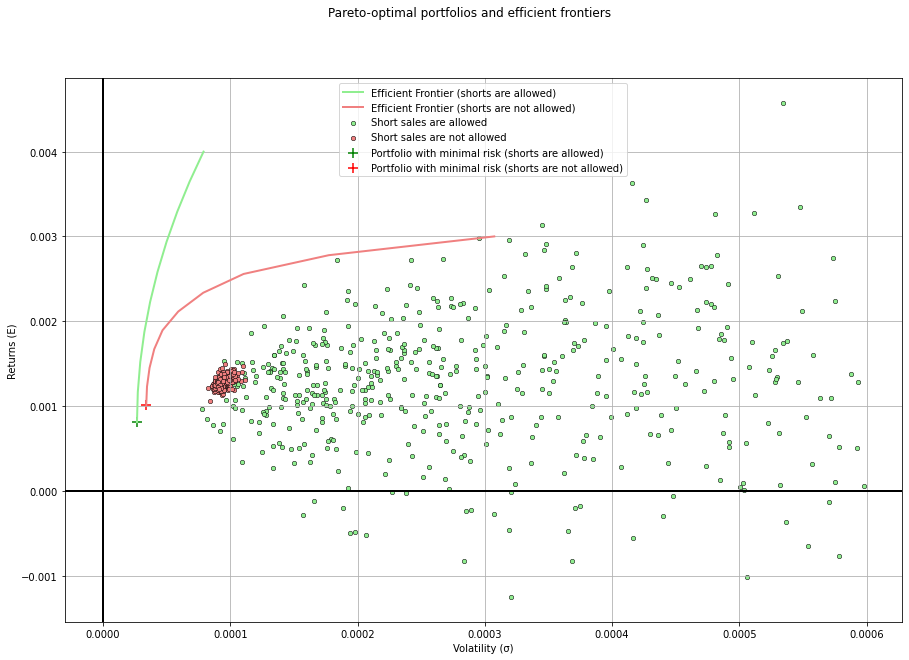

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Pareto-optimal portfolios and efficient frontiers")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# random portfolios plot
ax.scatter(random_portfolios_short_std_devs, random_portfolios_short_means, marker="o", color='lightgreen',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are allowed")
ax.scatter(random_portfolios_no_short_std_devs, random_portfolios_no_short_means, marker="o", color='lightcoral',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are not allowed")

# optimal frontier plot
ax.plot(opt_volatilities_short, target_returns_short, color="lightgreen", linewidth=2, label="Efficient Frontier (shorts are allowed)")
ax.plot(opt_volatilities_no_short, target_returns_no_short, color="lightcoral", linewidth=2, label="Efficient Frontier (shorts are not allowed)") 

# min risk plot 
ax.scatter(opt_short_volatility, opt_short_return, color="g", marker="+", s=100, label="Portfolio with minimal risk (shorts are allowed)")
ax.scatter(opt_no_short_volatility, opt_no_short_return, color="r", marker="+", s=100, label="Portfolio with minimal risk (shorts are not allowed)")

# equally weighted portfolio plot
#ax.scatter(eq_w_volatility, eq_w_return, color="b", marker="X", s=100, label="Equally weighted portfolio")

# market index plot
#ax.scatter(index_volatility, index_return, color="y", marker="X", s=100, label="Market index")

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

На графике видно, что эффективный фронт с запрещенными короткими продажами находится ниже, чем эффективным фронт с разрешенными короткими продажами, что говорит о том, что при равных рисках доходность на эффективном фронте с разрешенными короткими продажами всегда выше. 

Оптимальные портфели тоже отличаются. При разрешенных коротких продажах оптимальный портфель имеет меньший риск и меньшую доходность, чем оный при запрещенный коротких продажах. 

### Добавим на график портфель с равными долями и индекс рынка

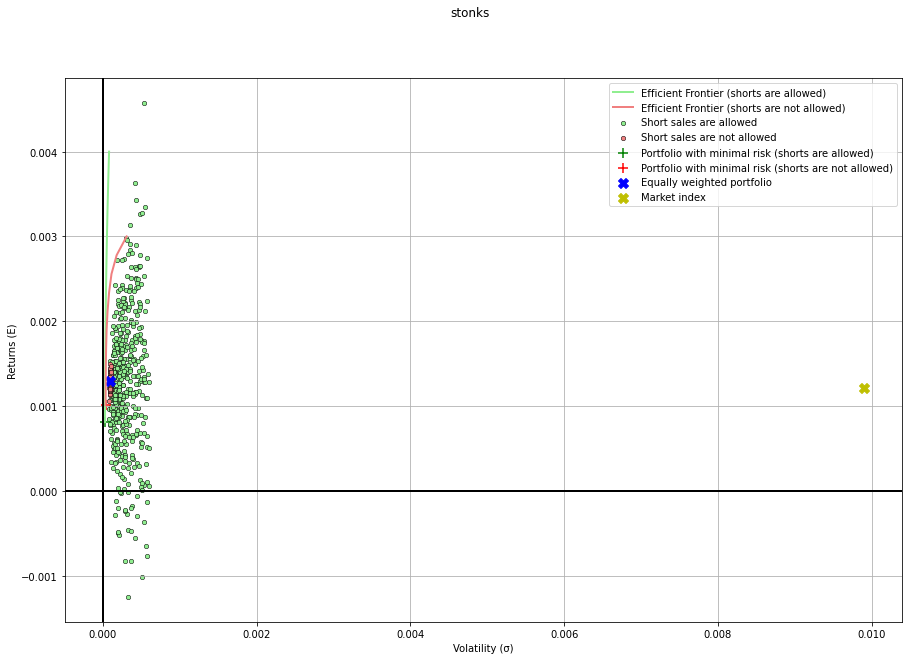

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("stonks")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# random portfolios plot
ax.scatter(random_portfolios_short_std_devs, random_portfolios_short_means, marker="o", color='lightgreen',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are allowed")
ax.scatter(random_portfolios_no_short_std_devs, random_portfolios_no_short_means, marker="o", color='lightcoral',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are not allowed")

# optimal frontier plot
ax.plot(opt_volatilities_short, target_returns_short, color="lightgreen", linewidth=2, label="Efficient Frontier (shorts are allowed)")
ax.plot(opt_volatilities_no_short, target_returns_no_short, color="lightcoral", linewidth=2, label="Efficient Frontier (shorts are not allowed)") 

# min risk plot 
ax.scatter(opt_short_volatility, opt_short_return, color="g", marker="+", s=100, label="Portfolio with minimal risk (shorts are allowed)")
ax.scatter(opt_no_short_volatility, opt_no_short_return, color="r", marker="+", s=100, label="Portfolio with minimal risk (shorts are not allowed)")

# equally weighted portfolio plot
ax.scatter(eq_w_volatility, eq_w_return, color="b", marker="X", s=100, label="Equally weighted portfolio")

# market index plot
ax.scatter(index_volatility, index_return, color="y", marker="X", s=100, label="Market index")

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

Индекс рынка находится очень далеко от фронта?

## 2. Portfolio selection problem. 

Требуется построить «хорошие» инвестиционные портфели из 10 активов вместо исходных 50 (или даже всех активов рынка). Предложите способ выбрать 10 активов (из отобранных ранее 50) для формирования портфеля. Сравните эффективные фронты всего набора (50 акций)  и выбранного набора активов (10 акций) для двух случаев
 - короткие продажи разрешены, 
 - короткие продажи запрещены.
 
 
 https://www.investopedia.com/terms/r/riskfreeasset.asp


### Рассчитаем коэффициент шарпа для всех 50 активов и выберем 10 активов с наибольшим его значением. 
В качестве безрискового актива положим "виртуальный" актив с доходностью 0.001

In [21]:
risk_free_return = 0.001

sharpe_ratios50 = pd.DataFrame((sample_means50 - risk_free_return).values * sample_std_devs50.values**(-1), 
                               columns=['Sharpe ratio'], 
                               index=sample_means50.index)

In [22]:
sharpe_ratios10 = sharpe_ratios50.sort_values(by=['Sharpe ratio'], ascending=False)[0:10]

tickers10 = list(sharpe_ratios10.index)
#tickers10 = tickers50[0:10]

sample_means10 = sample_means50.loc[tickers10]
sample_cov10 = sample_cov50.loc[tickers10][tickers10]

In [23]:
# optimal frontier for 10 stocks with short sales
x_opt_short10 = optimize_portfolio_volatility(sample_means10, sample_cov10, short_sales=True)

opt_short_return10 = calc_portfolio_return(x_opt_short10, sample_means10)
#opt_short_volatility10 = calc_portfolio_volatility(x_opt_short10, sample_cov10)

target_returns_short10 = np.linspace(opt_short_return10, 0.004, 10)
opt_volatilities_short10 = []

for target_return in target_returns_short10:
    x_opt = optimize_portfolio_volatility(sample_means10, sample_cov10, short_sales=True, custom_return=True, target_return=target_return)
    #opt_return = calc_portfolio_return(x_opt, sample_means50)
    opt_volatility = calc_portfolio_volatility(x_opt, sample_cov10)
    opt_volatilities_short10.append(opt_volatility)

Looking for a solution for 0.002087178447444101
Looking for a solution for 0.0022997141755058677
Looking for a solution for 0.002512249903567634
Looking for a solution for 0.002724785631629401
Looking for a solution for 0.002937321359691167
Looking for a solution for 0.003149857087752934
Looking for a solution for 0.0033623928158147006
Looking for a solution for 0.003574928543876467
Looking for a solution for 0.0037874642719382336
Looking for a solution for 0.004


In [24]:
# optimal frontier for 10 stocks with no short sales
x_opt_no_short10 = optimize_portfolio_volatility(sample_means10, sample_cov10, short_sales=False)

opt_no_short_return10 = calc_portfolio_return(x_opt_no_short10, sample_means10)
#opt_short_volatility10 = calc_portfolio_volatility(x_opt_short10, sample_cov10)

target_returns_no_short10 = np.linspace(opt_no_short_return10, 0.0031, 10)
opt_volatilities_no_short10 = []

for target_return in target_returns_no_short10:
    x_opt = optimize_portfolio_volatility(sample_means10, sample_cov10, short_sales=False, custom_return=True, target_return=target_return)
    #opt_return = calc_portfolio_return(x_opt, sample_means50)
    opt_volatility = calc_portfolio_volatility(x_opt, sample_cov10)
    opt_volatilities_no_short10.append(opt_volatility)


Looking for a solution for 0.002216996582783586
Looking for a solution for 0.0023151080735854097
Looking for a solution for 0.0024132195643872334
Looking for a solution for 0.002511331055189057
Looking for a solution for 0.002609442545990881
Looking for a solution for 0.0027075540367927048
Looking for a solution for 0.0028056655275945286
Looking for a solution for 0.0029037770183963523
Looking for a solution for 0.003001888509198176
Looking for a solution for 0.0031


### Изобразим эффективные фронты на графике

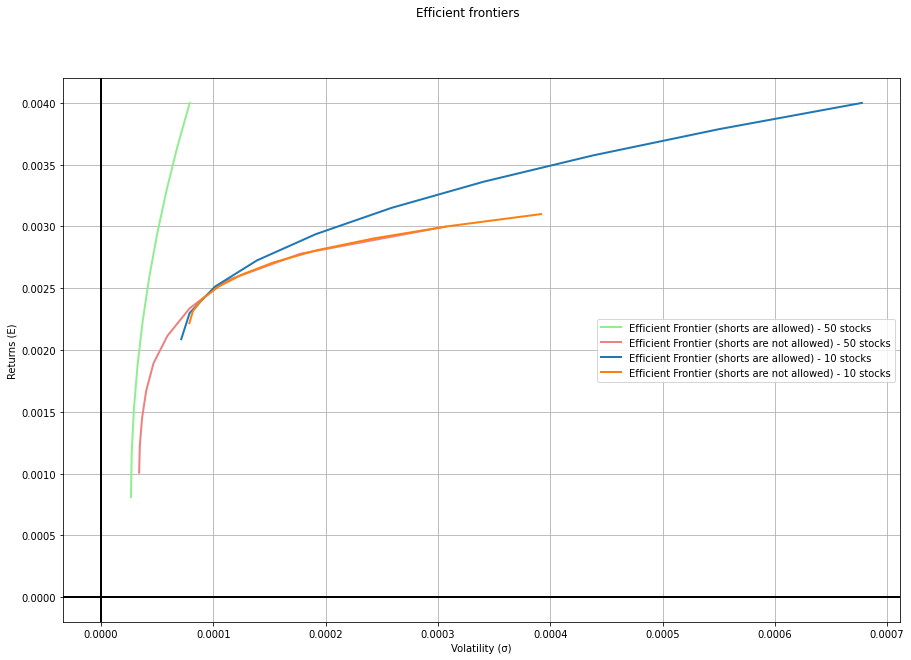

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Efficient frontiers")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# optimal frontier plot
ax.plot(opt_volatilities_short, target_returns_short, color="lightgreen", linewidth=2, label="Efficient Frontier (shorts are allowed) - 50 stocks")
ax.plot(opt_volatilities_no_short, target_returns_no_short, color="lightcoral", linewidth=2, label="Efficient Frontier (shorts are not allowed) - 50 stocks") 

ax.plot(opt_volatilities_short10, target_returns_short10, color="C0", linewidth=2, label="Efficient Frontier (shorts are allowed) - 10 stocks")
ax.plot(opt_volatilities_no_short10, target_returns_no_short10, color="C1", linewidth=2, label="Efficient Frontier (shorts are not allowed) - 10 stocks") 

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

Парето-эффективный портфель с 10 активами имеют заметно большую доходность, чем парето-эффективный портфель с 50 активами. Их риск тоже оказался выше, однако, не столь заметно, как доходность.

Эффективный фронт с разрешенными короткими продажами у портфеля из 10 активов намного менее "крутой", чем оный у портфеля из 50 активов, что говорит о том, что при одинаковом значении доходности риски у портфелей из 50 активов ниже. 

Можно заметить, что эффективный фронт с запрещенными продажами начиная со значения доходности 0.0025 совпадает у портфеля из 10 и 50 активов. 

## 3. Risk aversion.

Оцените свое отношение к риску и постройте свой личный оптимальный портфель инвестиций из выбранных 50-ти активов.  Дайте характеристику портфеля по составу и долям активов. Оцените VaR доходностей портфеля. Рассмотрите два случая: 
- короткие продажи разрешены, 
- короткие продажи запрещены.

In [26]:
def obj_func(X, returns, alpha, cov_matr):
    return - np.dot(returns, X) + alpha * calc_portfolio_volatility(X, cov_matr)
    
def get_portfolio_with_min_risk(obj_func, returns, cov_matr, alpha, bounds, tick_num):
    X = np.ones(tick_num)
    X = X/X.sum()
    bounds = bounds*tick_num
    
    constraints = []
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    
    return minimize(obj_func, X,
                    args=(returns, alpha, cov_matr), method='SLSQP', #МНК
                    constraints=constraints,
                    bounds=bounds).x

In [27]:
def risk_aversion(dist, alpha):
    tick_num = len(tickers50) 
    E = sample_means50['Sample mean (E)'].values 
    returns = log_returns50
    returns = returns.drop("Date", 1)
    bounds = ((-1, 1),) if dist=='short' else ((0, 1),)
    
    portfolio_weights = get_portfolio_with_min_risk(obj_func, E, sample_cov50, alpha, bounds, tick_num)
    
    min_std = calc_portfolio_volatility(portfolio_weights, sample_cov50)
    min_E = np.dot(portfolio_weights, E)
    losses = - np.dot(returns, portfolio_weights)
    return min_std, min_E, losses, portfolio_weights

### Короткие продажи разрешены:

$$ \begin{cases} E(x) - \alpha\sigma(x) \rightarrow  max \\ \sum x_i = 1 \end{cases} $$

Рассчитаем веса при 5-ти различных уровнях α: [1, 2, 3, 4, 5] и отметим полученные портфели на карте активов:

In [28]:
std1, E1, losses1, X1 = risk_aversion(dist='short', alpha=1)
std2, E2, losses2, X2 = risk_aversion(dist='short', alpha=2)
std3, E3, losses3, X3 = risk_aversion(dist='short', alpha=3)
std4, E4, losses4, X4 = risk_aversion(dist='short', alpha=4)
std5, E5, losses5, X5 = risk_aversion(dist='short', alpha=5)

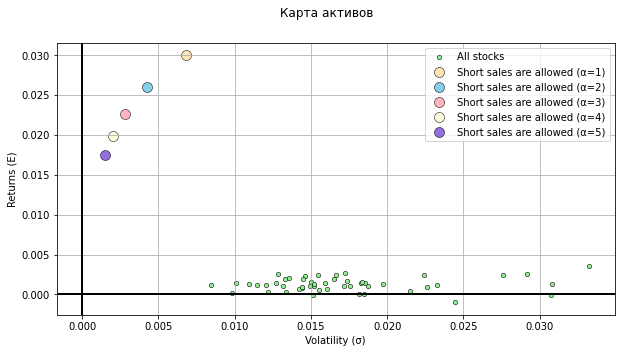

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Карта активов")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

ax.scatter(sample_std_devs50['Sample standard deviation (σ)'], sample_means50['Sample mean (E)'], marker="o", 
           color='lightgreen', edgecolors= 'black', linewidth=0.5, s=20, label='All stocks')
ax.scatter(std1, E1, marker="o", color='moccasin',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are allowed (α=1)")
ax.scatter(std2, E2, marker="o", color='skyblue',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are allowed (α=2)")
ax.scatter(std3, E3, marker="o", color='lightpink',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are allowed (α=3)")
ax.scatter(std4, E4, marker="o", color='lightyellow',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are allowed (α=4)")
ax.scatter(std5, E5, marker="o", color='mediumpurple',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are allowed (α=5)")

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

Как видно по графику, портфель с отношением к риску α=5 имеет самый низкий показатель стандартного отклонения. Поэтому этот портфель с наибольшим успехом диверсифицирует риск.

Построим столбчатую диаграмму, чтобы визуализировать рассчитанные веса при α=5:

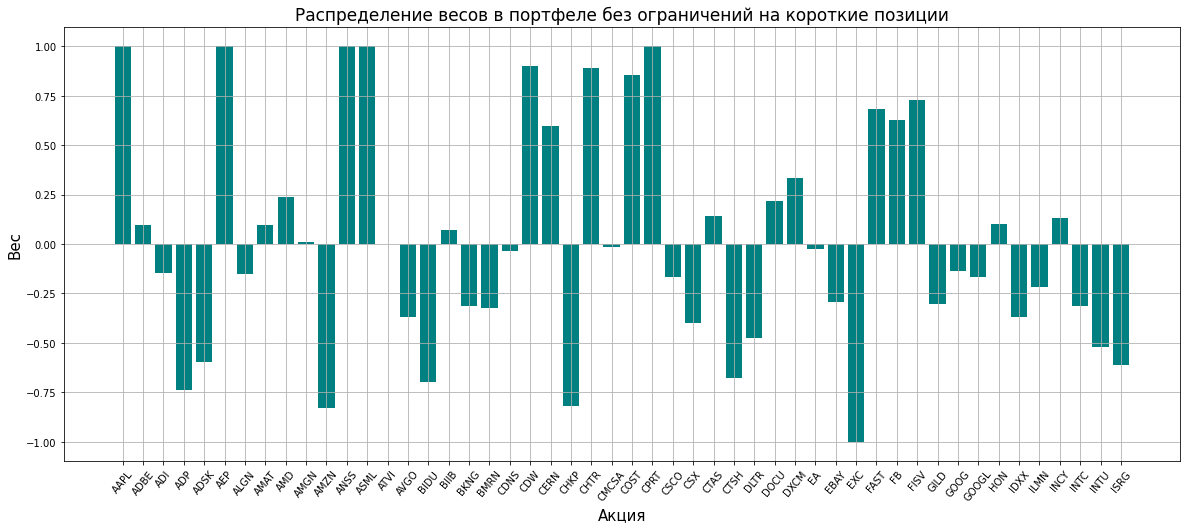

In [30]:
min_std1, min_E1, losses1, portfolio_weights1 = risk_aversion(dist='short', alpha=5)

weights_data = pd.DataFrame(index = tickers50, columns = ['weight'])
weights_data['weight'] = portfolio_weights1

plt.figure(figsize = (20,8))
x = np.arange(weights_data.shape[0])
x_values = weights_data.index
plt.xlabel('Акция', fontsize = 15)
plt.ylabel('Вес', fontsize = 15)
plt.bar(x, height = weights_data['weight'], color="teal")
plt.xticks(x, x_values, rotation='50')
plt.title("Распределение весов в портфеле без ограничений на короткие позиции", fontsize = 17)
plt.grid()

Итак, самые маленькие веса у компаний:
- AMGN (AMGen Inc.) - биотехнологии
- ATVI (Activision Blizzard) - индустрия компьютерных игр
- CDNS (Cadence Design Systems) - разработка ПО
- CMCSA (Comcast) - телекоммуникации
- EA (Electronic Arts) - индустрия компьютерных игр

Самые большие веса: 
- AAPL (Apple) - электроника, разработка ПО
- AEP (American Electric Power) - электроэнергетика
- ANSS (Ansys Inc.) - ПО и услуги для инженерного моделирования
- ASML (ASML Holding N.V.) - микроэлектронная промышленность
- CPRT (Copart) -  услуги онлайн-аукционов и ремаркетинга автомобилей
- EXC (Exelon Corporation) - энергетика

Портфель очень разнообразен по составу. Каких-либо закономерностей относительно характера распределения весов выявлено не было. 

#### Теперь оценим VaR доходностей этого портфеля:

In [31]:
сonfidence_levels = [0.9, 0.95, 0.99]
VaR = {}

print('VaR для портфеля с отношением к риску α=5 без ограничений на короткие позиции:')

for level in сonfidence_levels:
    VaR[level] = np.quantile(losses1, level)
    print('- Потери не превысят %.5f с уверенностью %.f%s.' % (np.round(VaR[level],5), level*100, '%'))

VaR для портфеля с отношением к риску α=5 без ограничений на короткие позиции:
- Потери не превысят 0.02989 с уверенностью 90%.
- Потери не превысят 0.04548 с уверенностью 95%.
- Потери не превысят 0.07417 с уверенностью 99%.


### Короткие продажи запрещены:

$$ \begin{cases}  E(x) - \alpha\sigma(x) \rightarrow  max \\ \sum x_i = 1 \\ x_i > 0 \quad \forall i\end{cases} $$

Снова рассчитаем веса при 5-ти различных уровнях α: [1, 2, 3, 4, 5] и отметим полученные портфели на карте активов:

In [32]:
std11, E11, losses11, X11 = risk_aversion(dist='short_sales_are_not_allowed', alpha=1)
std22, E22, losses22, X22 = risk_aversion(dist='short_sales_are_not_allowed', alpha=2)
std33, E33, losses33, X33 = risk_aversion(dist='short_sales_are_not_allowed', alpha=3)
std44, E44, losses44, X44 = risk_aversion(dist='short_sales_are_not_allowed', alpha=4)
std55, E55, losses55, X55 = risk_aversion(dist='short_sales_are_not_allowed', alpha=5)

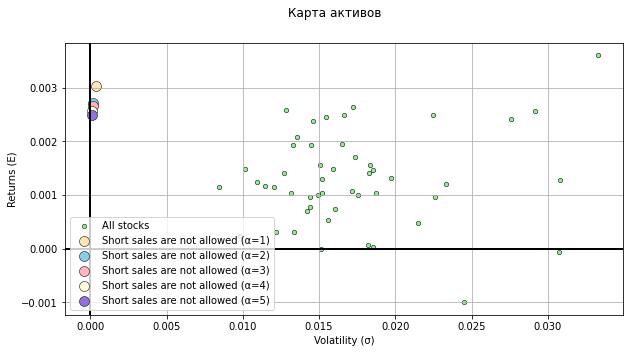

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Карта активов")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

ax.scatter(sample_std_devs50['Sample standard deviation (σ)'], sample_means50['Sample mean (E)'], marker="o", 
           color='lightgreen', edgecolors= 'black', linewidth=0.5, s=20, label='All stocks')
ax.scatter(std11, E11, marker="o", color='moccasin',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are not allowed (α=1)")
ax.scatter(std22, E22, marker="o", color='skyblue',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are not allowed (α=2)")
ax.scatter(std33, E33, marker="o", color='lightpink',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are not allowed (α=3)")
ax.scatter(std44, E44, marker="o", color='lightyellow',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are not allowed (α=4)")
ax.scatter(std55, E55, marker="o", color='mediumpurple',
           edgecolors= 'black', linewidth=0.5, s=100, label="Short sales are not allowed (α=5)")

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

Самое низкое стандартное отклонение имеет портфель, построенный с отношением к риску α=5. Визуализируем распределение весов между компаниями в этом портфеле:

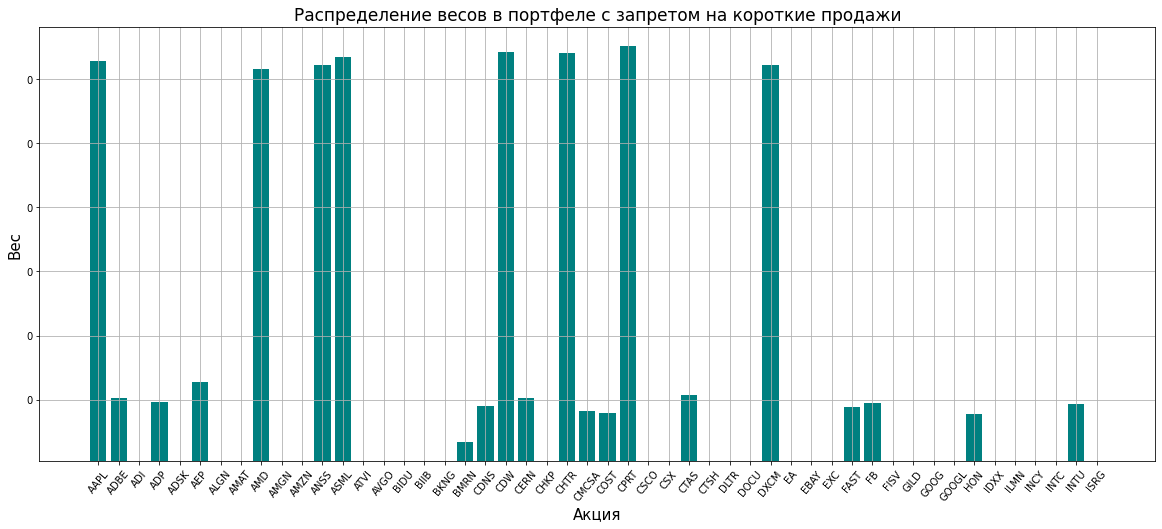

In [34]:
min_std2, min_E2, losses2, portfolio_weights2 = risk_aversion(dist='short_sales_are_not_allowed', alpha=5)

weights_data1 = pd.DataFrame(index = tickers50, columns = ['weight'])
weights_data1['weight'] = portfolio_weights2

plt.figure(figsize = (20,8))
x = np.arange(weights_data1.shape[0])
x_values = weights_data1.index
plt.xlabel('Акция', fontsize = 15)
plt.ylabel('Вес', fontsize = 15)
plt.bar(x, height = weights_data1['weight'], color='teal')
plt.xticks(x, x_values, rotation='50')
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.title("Распределение весов в портфеле с запретом на короткие продажи", fontsize = 17)
plt.grid()

Как видно по графику, наибольшие веса у компаний:
- AAPL (Apple) - электроника, разработка ПО
- AMD (Advanced Micro Devices) - электронные компоненты
- ANSS (Ansys Inc.) - ПО и услуги для инженерного моделирования
- ASML (ASML Holding N.V.) - микроэлектронная промышленность
- CDW (CDW Corporation) - информационные технологии
- CHTR (Charter Communications) - телекоммуникации
- CPRT (Copart) - услуги онлайн-аукционов и ремаркетинга автомобилей
- DXCM (Dexcom) - медицинское оборудование и принадлежности

Таким образом, приоритетными отраслями являются электроника и информационные технологии.

#### Оценим VaR доходностей этого портфеля:

In [35]:
сonfidence_levels = [0.9, 0.95, 0.99]
VaR = {}

print('VaR для портфеля с отношением к риску α=5 с запретом на короткие продажи:')

for level in сonfidence_levels:
    VaR[level] = np.quantile(losses2, level)
    print('- Потери не превысят %.5f с уверенностью %.f%s.' % (np.round(VaR[level],5), level*100, '%'))

VaR для портфеля с отношением к риску α=5 с запретом на короткие продажи:
- Потери не превысят 0.00986 с уверенностью 90%.
- Потери не превысят 0.01256 с уверенностью 95%.
- Потери не превысят 0.03049 с уверенностью 99%.


## 3. Risk aversion and Portfolio selection. 

Используя выбранное  в п.3 отношение к риску постройте  оптимальный портфель из 10 активов (вместо 50, см. п.2). Дайте характеристику этого портфеля по составу активов и долям инвестиций. Сравните с портфелем п.3. Оцените VaR доходностей портфеля. Рассмотрите два случая: 
- короткие продажи разрешены, 
- короткие продажи запрещены.

Можно ли ваш портфель из 10 активов улучшить, оставаясь в рамках 10 активов из выбранных ранее 50 активов?

In [36]:
#10 компаний, выбранных с помощью коэффициента Шарпа в п.2.
tickers10

['CPRT', 'ASML', 'ANSS', 'CDW', 'AAPL', 'CHTR', 'AMD', 'CTAS', 'AMAT', 'FISV']

In [37]:
log_returns10 = log_returns50[tickers10]

def risk_aversion_v2(dist, alpha):
    tick_num = len(tickers10) 
    E = sample_means10['Sample mean (E)'].values 
    returns = log_returns10
    bounds = ((-1, 1),) if dist=='short' else ((0, 1),)
    
    portfolio_weights = get_portfolio_with_min_risk(obj_func, E, sample_cov10, alpha, bounds, tick_num)
    
    min_std = calc_portfolio_volatility(portfolio_weights, sample_cov10)
    min_E = np.dot(portfolio_weights, E)
    losses = - np.dot(returns, portfolio_weights)
    return min_std, min_E, losses, portfolio_weights

### Короткие продажи разрешены:

Построим оптимальный портфель с отношением к риску α=5:

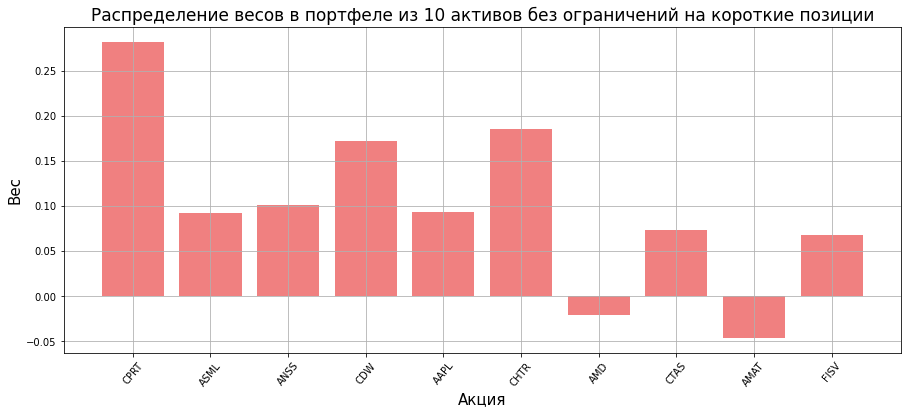

In [38]:
std_short, E_short, loss_short, weights_short = risk_aversion_v2(dist='short', alpha=5)

weights_data = pd.DataFrame(index = tickers10, columns = ['weight'])
weights_data['weight'] = weights_short

plt.figure(figsize = (15,6))
x = np.arange(weights_data.shape[0])
x_values = weights_data.index
plt.xlabel('Акция', fontsize = 15)
plt.ylabel('Вес', fontsize = 15)
plt.bar(x, height = weights_data['weight'], color="lightcoral")
plt.xticks(x, x_values, rotation='50')
plt.title("Распределение весов в портфеле из 10 активов без ограничений на короткие позиции", fontsize = 17)
plt.grid()

#### Список компаний в порядке убывания веса в портфеле:

1. CPRT (Copart) - услуги онлайн-аукционов и ремаркетинга автомобилей
2. CHTR (Charter Communications) - телекоммуникации
3. CDW (CDW Corporation) - информационные технологии
4. ANSS (Ansys Inc.) - ПО и услуги для инженерного моделирования
5. AAPL (Apple) - электроника, разработка ПО
6. ASML (ASML Holding N.V.) - микроэлектронная промышленность
7. CTAS (Cintas) - промышленность, коммерческие услуги и поставки
8. FISV (Fiserv) - компьютерные услуги и технологии
9. AMAT (Applied Materials) - микроэлектронная промышленность
10. AMD (Advanced Micro Devices) - электронные компоненты

Следует отметить, что первые 6 компаний из вышеприведенного списка также занимают лидирующие позиции по весам в портфеле, построенном в п.3. Что касается компаний под номерами 7-10, в портфеле из 50-ти активов они также имели минимальные веса.

Если говорить об отраслевом составе портфеля, то здесь ничего кардинально не изменилось: большинство компаний в портфеле принадлежат к отраслям электроника и информационные технологии.

#### Оценим VaR доходностей этого портфеля:

In [39]:
сonfidence_levels = [0.9, 0.95, 0.99]
VaR = {}

print('VaR для портфеля из 10 активов с отношением к риску α=5 без запрета на короткие продажи:')

for level in сonfidence_levels:
    VaR[level] = np.quantile(loss_short, level)
    print('- Потери не превысят %.5f с уверенностью %.f%s.' % (np.round(VaR[level],5), level*100, '%'))

VaR для портфеля из 10 активов с отношением к риску α=5 без запрета на короткие продажи:
- Потери не превысят 0.00744 с уверенностью 90%.
- Потери не превысят 0.01177 с уверенностью 95%.
- Потери не превысят 0.02858 с уверенностью 99%.


### Короткие продажи запрещены:

Построим оптимальный портфель с отношением к риску α=5.

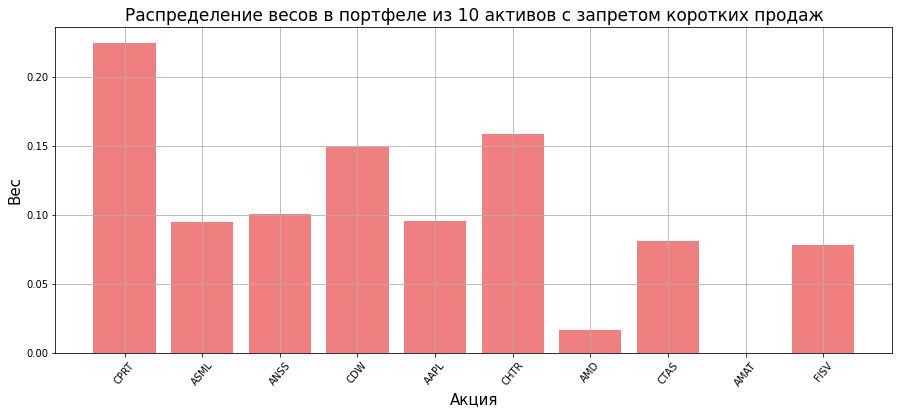

In [40]:
std_not_short, E_not_short, loss_not_short, weights_not_short = risk_aversion_v2(dist='short_sales_are_not_allowed', alpha=5)

weights_data = pd.DataFrame(index = tickers10, columns = ['weight'])
weights_data['weight'] = weights_not_short

plt.figure(figsize = (15,6))
x = np.arange(weights_data.shape[0])
x_values = weights_data.index
plt.xlabel('Акция', fontsize = 15)
plt.ylabel('Вес', fontsize = 15)
plt.bar(x, height = weights_data['weight'], color="lightcoral")
plt.xticks(x, x_values, rotation='50')
plt.title("Распределение весов в портфеле из 10 активов с запретом коротких продаж", fontsize = 17)
plt.grid()

При добавлении ограничений на короткие позиции, распределение долей в портфеле осталось примерно таким же, за исключением компаний AMD и AMAT. Applied Materials спустилась на последнее место по доле инвестиций.

Если сравнивать этот портфель с портфелем, построенном в п.3. с запретом на короткие позиции, то можно заметить, что паттерн распределения долей инвестиций примерно одинаков. Исключение составляет лишь компания Advanced Micro Devices. В портфеле из 10-ти активов она занимает последние позиции по весу, в то время как в портфеле из 50-ти активов она находится в числе лидеров по долям инвестирования.

#### Оценим VaR доходностей этого портфеля:

In [41]:
сonfidence_levels = [0.9, 0.95, 0.99]
VaR = {}

print('VaR для портфеля из 10 активов с отношением к риску α=5 с запретом на короткие продажи:')

for level in сonfidence_levels:
    VaR[level] = np.quantile(loss_not_short, level)
    print('- Потери не превысят %.5f с уверенностью %.f%s.' % (np.round(VaR[level],5), level*100, '%'))

VaR для портфеля из 10 активов с отношением к риску α=5 с запретом на короткие продажи:
- Потери не превысят 0.00779 с уверенностью 90%.
- Потери не превысят 0.01272 с уверенностью 95%.
- Потери не превысят 0.03192 с уверенностью 99%.
